In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os 
import numpy as np

Using TensorFlow backend.


In [2]:
import zipfile

path = os.getcwd()
train = r'tmp2\rps.zip'
train_path = os.path.join(path,train)
zip_ref = zipfile.ZipFile(train_path,'r')
zip_ref.extractall(os.path.join(path,'tmp2'))
zip_ref.close()

test = r'tmp2\rps-test-set.zip'
test_path = os.path.join(path,test)
zip_ref = zipfile.ZipFile(test_path,'r')
zip_ref.extractall(os.path.join(path,'tmp2'))
zip_ref.close()

In [3]:
train = r'tmp2\rps'
test = r'tmp2\rps-test-set'
train_dir = os.path.join(path,train)
val_dir = os.path.join(path,test)

im_rock = len(os.listdir(os.path.join(train_dir,'rock'))) # total images of rock
print(im_rock)

rock_name = os.listdir(os.path.join(train_dir,r'rock'))
paper_name = os.listdir(os.path.join(train_dir,r'paper'))
scissor_name = os.listdir(os.path.join(train_dir,r'scissors'))

vrock_name = os.listdir(os.path.join(val_dir,r'rock'))
vpaper_name = os.listdir(os.path.join(val_dir,r'paper'))
vscissor_name = os.listdir(os.path.join(val_dir,r'scissors'))

840


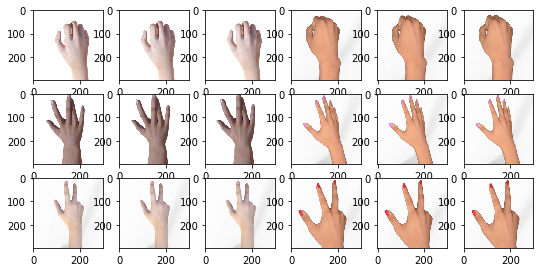

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(9,9)
num_pics = 4

rock_pics = [os.path.join(os.path.join(train_dir,r'rock'),fname) for fname in rock_name[num_pics-3:num_pics]] + [os.path.join(os.path.join(val_dir,r'rock'),fname) for fname in vrock_name[num_pics-3:num_pics]]
paper_pics = [os.path.join(os.path.join(train_dir,r'paper'),fname) for fname in paper_name[num_pics-3:num_pics]] + [os.path.join(os.path.join(val_dir,r'paper'),fname) for fname in vpaper_name[num_pics-3:num_pics]]
scissor_pics = [os.path.join(os.path.join(train_dir,r'scissors'),fname) for fname in scissor_name[num_pics-3:num_pics]] + [os.path.join(os.path.join(val_dir,r'scissors'),fname) for fname in vscissor_name[num_pics-3:num_pics]]

for i,im in enumerate(rock_pics+paper_pics+scissor_pics):
    ax = plt.subplot(6,6,i+1)
    #print(im)
    img = mpimg.imread(im)
    plt.imshow(img)
plt.show()

In [5]:
from keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(input_shape = (150,150,3),
                       include_top = False,
                       weights = 'imagenet')
for layer in resnet_model.layers:
    layer.trainable = False
resnet_model.summary()

C:\Users\shaur\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
# using add_12 layer as output  :
last_res_layer = resnet_model.get_layer('activation_45')
print(last_res_layer.output_shape)
last_layer = last_res_layer.output

X = layers.Flatten()(last_layer)
X = layers.Dropout(0.5)(X)
X = layers.Dense(64,activation = 'relu')(X)
X = layers.Dense(3,activation = 'softmax')(X)

model = Model(resnet_model.input,X)

(None, 5, 5, 512)


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [8]:
class CALLBACK(keras.callbacks.Callback):
    def at_the_end(self,epoch,log = {}):
        if log.get('accuracy') > 0.98:
            print("\n accuracy reached 98% stopping training ...")
            self.model.stop_training = True

In [9]:
optmz = keras.optimizers.RMSprop(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy',
             optimizer = optmz,
             metrics = ['accuracy'])

train_data_gen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_data_gen = ImageDataGenerator(rescale = 1/255)

train_gen = train_data_gen.flow_from_directory(train_dir,
                                              target_size = (150,150),
                                              class_mode = 'categorical',
                                              batch_size = 126) # total images in set = 840x3
val_gen = val_data_gen.flow_from_directory(val_dir,
                                          target_size = (150,150),
                                          class_mode = 'categorical',
                                          batch_size = 31) # total images in set = 124x3

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [10]:
history = model.fit_generator(train_gen,
                             epochs = 25,
                             steps_per_epoch = 20,
                             validation_data = val_gen,
                             verbose = 1,
                             validation_steps = 12,
                             callbacks = [CALLBACK()]) 

Epoch 1/25
20/20 [==============================] - 385s 19s/step - loss: 4.8402 - accuracy: 0.7159 - val_loss: 1.2519 - val_accuracy: 0.3871
Epoch 2/25
20/20 [==============================] - 385s 19s/step - loss: 0.3769 - accuracy: 0.9095 - val_loss: 1.2186 - val_accuracy: 0.3011
Epoch 3/25
20/20 [==============================] - 380s 19s/step - loss: 0.1525 - accuracy: 0.9540 - val_loss: 1.8532 - val_accuracy: 0.3333
Epoch 4/25
20/20 [==============================] - 381s 19s/step - loss: 0.1772 - accuracy: 0.9373 - val_loss: 1.2215 - val_accuracy: 0.4140
Epoch 5/25
20/20 [==============================] - 379s 19s/step - loss: 0.1467 - accuracy: 0.9563 - val_loss: 1.2300 - val_accuracy: 0.2984
Epoch 6/25
20/20 [==============================] - 377s 19s/step - loss: 0.1428 - accuracy: 0.9548 - val_loss: 1.8696 - val_accuracy: 0.3333
Epoch 7/25
20/20 [==============================] - 378s 19s/step - loss: 0.1228 - accuracy: 0.9540 - val_loss: 1.3301 - val_accuracy: 0.2984
Epoch 

KeyboardInterrupt: 